In [3]:
import random

class Sentiment:
    Positive='POSITIVE'
    Negative='NEGATIVE'
    Neutral='NEUTRAL'

class Reviews:
    def __init__(self, review,score):
        self.text=review
        self.score=score
        self.sentiment=self.get_sentiment()
        
    def get_sentiment(self):
        if(self.score>=4):
            return Sentiment.Positive
        elif(self.score==3):
            return Sentiment.Neutral
        else:
            return Sentiment.Negative
        
class Container:
    def __init__(self,reviews):
        self.reviews=reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def distribute(self):
        negativerev=list(filter(lambda x: x.sentiment == Sentiment.Negative,self.reviews))
        positiverev=list(filter(lambda x: x.sentiment == Sentiment.Positive,self.reviews))
        new=positiverev[:len(negativerev)]
        self.reviews=negativerev+new
        random.shuffle(self.reviews)

Gathering data

In [4]:
import json
file="./data/booksrev10000.json"

reviews=[]
with open(file) as f:
    for i in f:
        revdata=json.loads(i)
        reviews.append(Reviews(revdata['reviewText'],revdata['overall']))

reviews[10].sentiment

'POSITIVE'

Prep the data

In [5]:
from sklearn.model_selection import train_test_split

train, test=train_test_split(reviews,test_size=0.3, random_state=30)

# x is feature(input-> text), y is target(output-> score)

train_container=Container(train)
test_container=Container(test)

train_container.distribute()
train_x= train_container.get_text()
train_y= train_container.get_sentiment()

test_container.distribute()
test_x= test_container.get_text()
test_y= test_container.get_sentiment()



Use Bag of Words (BOW) method to convert text data into numerical data

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer()

train_x_vect=vectorizer.fit_transform(train_x)

test_x_vect=vectorizer.transform(test_x)



Now that the data is ready, apply the data to models to see outputs

Support vector machine:



In [7]:
from sklearn import svm
clf_svc= svm.SVC(kernel='linear')
clf_svc.fit(train_x_vect,train_y)
print(clf_svc.predict(test_x_vect[0]))

test_x[0]

['POSITIVE']


'The sad reality of what happens to children raised in an abusive situation. My heart went out to the young man when he was finally faced with the reality. Hi success nd how he managed is a great story.'

Decision tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vect,train_y)
clf_dec.predict(test_x_vect[0])

array(['POSITIVE'], dtype='<U8')

Gaussian naive bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

clf_nvb=GaussianNB()
clf_nvb.fit(train_x_vect.toarray(), train_y)
clf_nvb.predict(test_x_vect[0].toarray())


array(['POSITIVE'], dtype='<U8')

Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vect, train_y)
clf_log.predict(test_x_vect[0])

array(['POSITIVE'], dtype='<U8')

Now check score of each model to find mean accuracy

In [11]:
print(clf_svc.score(test_x_vect,test_y))
print(clf_dec.score(test_x_vect,test_y))
print(clf_nvb.score(test_x_vect.toarray(),test_y))
print(clf_log.score(test_x_vect,test_y))

0.860655737704918
0.674863387978142
0.6065573770491803
0.8524590163934426


Check f1 scores of the models

In [12]:
from sklearn.metrics import f1_score

print(f1_score(test_y,clf_svc.predict(test_x_vect),average=None,labels=[Sentiment.Positive,Sentiment.Negative]))
print(f1_score(test_y,clf_dec.predict(test_x_vect),average=None,labels=[Sentiment.Positive,Sentiment.Negative]))
print(f1_score(test_y,clf_nvb.predict(test_x_vect.toarray()),average=None,labels=[Sentiment.Positive,Sentiment.Negative]))
print(f1_score(test_y,clf_log.predict(test_x_vect),average=None,labels=[Sentiment.Positive,Sentiment.Negative]))

[0.85950413 0.86178862]
[0.67750678 0.67217631]
[0.61904762 0.59322034]
[0.85326087 0.85164835]


Improving the model (dividing the data equally so that the data is not biased)

In [13]:
print(train_y.count(Sentiment.Positive))
print(train_y.count(Sentiment.Negative))
print(len(train_x))
print(test_y.count(Sentiment.Positive))
print(test_y.count(Sentiment.Negative))
print(len(test_x))

461
461
922
183
183
366


In [14]:
test_set = ['very fun', "bad book do not buy", 'horrible waste of time']
new_data=vectorizer.transform(test_set)
print(clf_svc.predict(new_data))
print(clf_dec.predict(new_data))
print(clf_nvb.predict(new_data.toarray()))
print(clf_log.predict(new_data))


['POSITIVE' 'NEGATIVE' 'NEGATIVE']
['POSITIVE' 'NEGATIVE' 'NEGATIVE']
['POSITIVE' 'POSITIVE' 'NEGATIVE']
['POSITIVE' 'NEGATIVE' 'NEGATIVE']


Saving our model (using pickle)

In [15]:
import pickle

In [16]:
with open('./models/sentiment_classifier.pkl','+wb') as b:
    pickle.dump(clf_svc,b)

In [17]:
with open('./models/sentiment_classifier.pkl','+rb') as b:
    load_clf= pickle.load(b)

In [18]:
print(test_x[0])
load_clf.predict(test_x_vect[0])

The sad reality of what happens to children raised in an abusive situation. My heart went out to the young man when he was finally faced with the reality. Hi success nd how he managed is a great story.


array(['POSITIVE'], dtype='<U8')

Drawing a heatmap


In [28]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib as plt
import seaborn as sn

svc_pred=clf_svc.predict(test_x_vect)
dec_pred=clf_dec.predict(test_x_vect)
nvb_pred=clf_nvb.predict(test_x_vect.toarray())
log_pred=clf_log.predict(test_x_vect)

lbls=[Sentiment.Positive, Sentiment.Negative]

svc_cm=confusion_matrix(test_y,svc_pred,labels=lbls)
dec_cm=confusion_matrix(test_y,dec_pred,labels=lbls)
nvb_cm=confusion_matrix(test_y,nvb_pred,labels=lbls)
log_cm=confusion_matrix(test_y,log_pred,labels=lbls)

Svc heatmap

<Axes: >

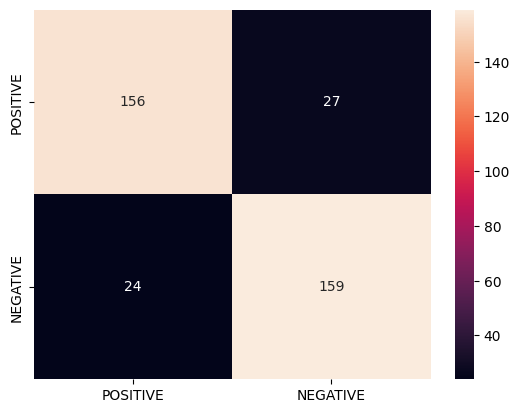

In [35]:
svc_df=pd.DataFrame(svc_cm,index=lbls,columns=lbls)
sn.heatmap(svc_df,annot=True,fmt='d')

Decision Tree heatmap

<Axes: >

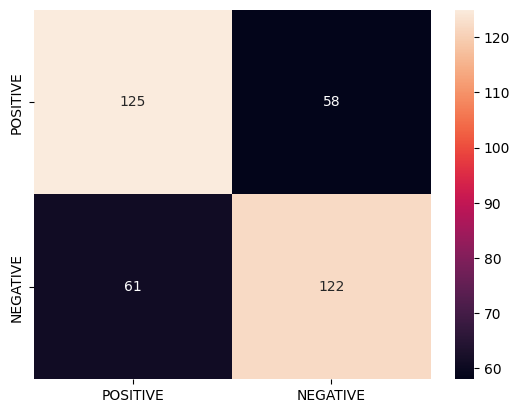

In [36]:
dec_df=pd.DataFrame(dec_cm,index=lbls,columns=lbls)
sn.heatmap(dec_df,annot=True,fmt='d')

Naive bayes heatmap

<Axes: >

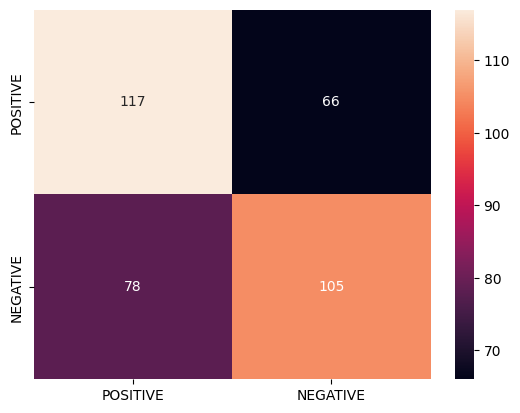

In [37]:
nvb_df=pd.DataFrame(nvb_cm,index=lbls,columns=lbls)
sn.heatmap(nvb_df,annot=True,fmt='d')

Logistic regression heat map

<Axes: >

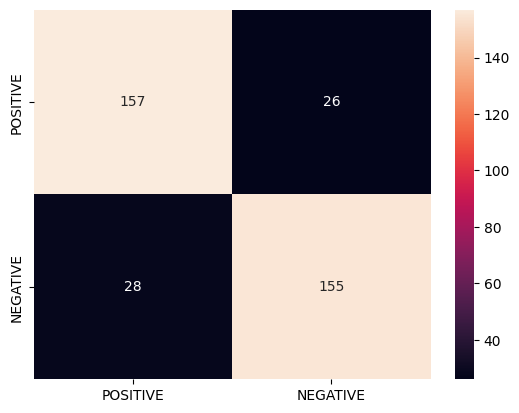

In [38]:
log_df=pd.DataFrame(log_cm,index=lbls,columns=lbls)
sn.heatmap(log_df,annot=True,fmt='d')